In [8]:
using CSV, DataFrames, Flux, Plots

In [11]:
data = CSV.read("airline-passengers.csv", DataFrame)

Row,Month,Passengers
,Date,Int64
1,1949-01-01,112
2,1949-02-01,118
3,1949-03-01,132
4,1949-04-01,129
5,1949-05-01,121
6,1949-06-01,135
7,1949-07-01,148
8,1949-08-01,148
9,1949-09-01,136


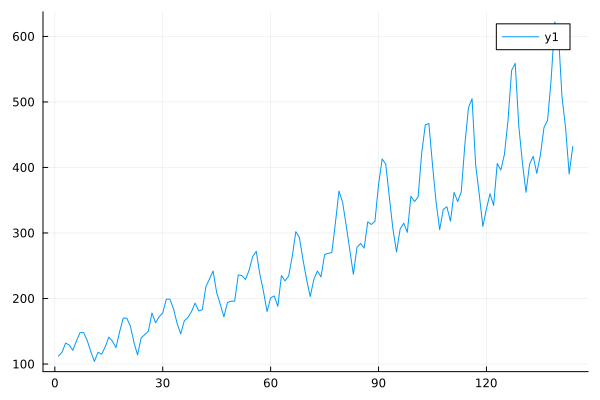

In [18]:
training_set = data.Passengers
plot(training_set)

In [21]:
function min_max_scaler(data)
    min_d = minimum(data)
    max_d = maximum(data)
    return (data .- min_d) ./ (max_d - min_d)
end

sliding_window(data, seq_length) = [
    @view data[i:i+seq_length-1] for i in 1:length(data)-seq_length+1
]

sliding_window (generic function with 1 method)

In [66]:
training_data = Float32.(min_max_scaler(training_set))

seq_length = 4
x = sliding_window(training_data, seq_length)
y = @view training_data[seq_length:end]

train_size = floor(Int, length(y) *2/3)
test_size = length(y) - train_size

trainX = @view x[1:train_size]
trainY = @view y[1:train_size]

testX = @view x[train_size+1:end]
testY = @view y[train_size+1:end]

47-element view(::Vector{Float32}, 98:144) with eltype Float32:
 0.38030887
 0.4864865
 0.47104248
 0.484556
 0.6138996
 0.6969112
 0.7007722
 0.57915056
 0.46911198
 0.3880309
 0.44787645
 0.45559844
 0.41312742
 ⋮
 0.6042471
 0.5540541
 0.6081081
 0.6891892
 0.7104247
 0.83204633
 1.0
 0.969112
 0.7799228
 0.6891892
 0.55212355
 0.63320464

In [120]:
model = Chain(
    LSTM(4 => 2),
    Dense(2 => 1, identity)
)

Chain(
  Recur(
    LSTMCell(4 => 2),                   # 60 parameters
  ),
  Dense(2 => 1),                        # 3 parameters
)         # Total: 7 trainable arrays, 63 parameters,
          # plus 2 non-trainable, 4 parameters, summarysize 724 bytes.

In [121]:
"""
    loss(model, x::AbstractArray{T,1}, y::T)

Single-element loss function
"""
function loss(model, x::AbstractArray{T,1}, y::T) where T <: Number
    Flux.Losses.mse(model(x), y)
end

"""
    loss(model, X::B, Y::A) where {T <: Number, A <: AbstractArray{T,1}, B <: AbstractArray{<:A, 1}}

Vector-based loss function.
"""
function loss(model, X::B, Y::A) where {T <: Number, A <: AbstractArray{T,1}, B <: AbstractArray{<:A, 1}}
    model(X[1]) # ignores the output but updates the hidden states -- sometimes called "warmup"
    sum(loss(model, xi, yi) for (xi, yi) in zip(X[2:end], Y[2:end]))
end

loss

In [122]:
loss(model, testX[1], testY[1])

0.143704f0

In [123]:
epochs = 2000
opt = Adam(1e-4)
θ = Flux.params(model) # Keep track of the model parameters
losses_train = Float32[] # a Float32 array
losses_test  = Float32[]
loss_fn(x, y) = loss(model, x, y)
for epoch ∈ 1:epochs # Training loop
    Flux.reset!(model) # Reset the hidden state of the RNN
    # model(X[1])
    Flux.train!(loss_fn, θ, zip(trainX[2:end], trainY[2:end]), opt)
    train_loss = loss_fn(trainX, trainY)
    test_loss = loss_fn(testX, testY)
    print("$(epoch): Train Loss = $(train_loss), Test Loss = $(test_loss)            \r")
    push!(losses_train, train_loss)
    push!(losses_test, test_loss)
end

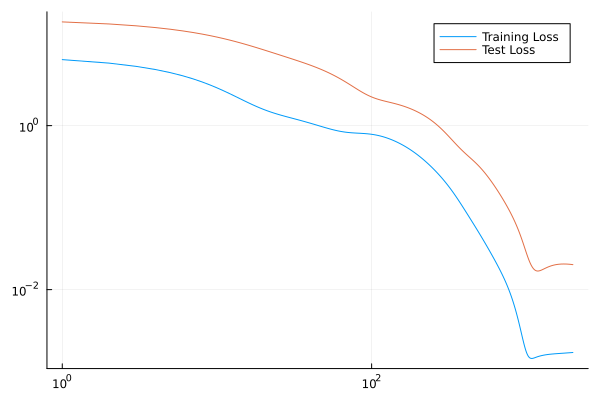

In [124]:
plot(losses_train, label="Training Loss")
plot!(losses_test, label="Test Loss")
plot!(xscale=:log, yscale=:log)

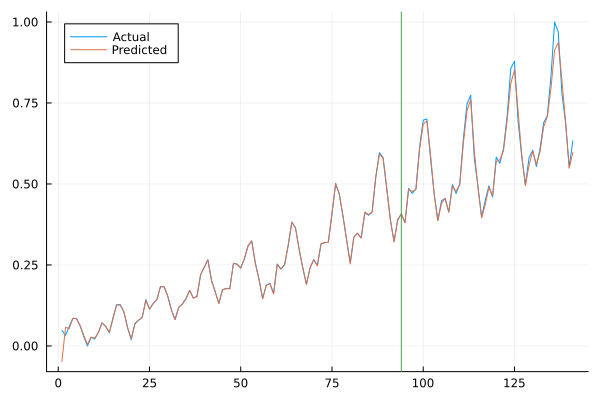

In [125]:
predicted = [
    begin @assert(length(r)==0); x end for (x,r...) ∈ model.(x)
]
plot(y, label="Actual")
plot!(predicted, label="Predicted")
plot!(legend=:topleft)
vline!([train_size], label=nothing)

In [84]:
?vline!

search: vline! vline ConcurrencyViolationError



```
vline(x)
vline!(x)
```

Draw vertical lines at positions specified by the values in the AbstractVector `x`

# Example

```julia-repl
julia> vline([-1,0,2])
```
